# Analysis for once-through scenarios
This notebook provides analysis for all of the once-through fuel cycle scenarios that are included in 
Amanda Bachmann's dissertation. Analysis of each scenario includes the number of reactors deployed, the uranium resources, the SWU capacity, and the amount of waste produced. 

Scenarios are numbers as follows:
* 1: LWRs
* 2: MMR, no growth
* 3: Xe-100, no growth
* 4: Xe-100 and MMR, no growth
* 5: MMR and VOYGR, no growth
* 6: Xe-100 and VOYGR, no growth
* 7: Xe-100, MMR, and VOYGR, no growth
* 8: MMR, 1% growth
* 9: Xe-100, 1% growth
* 10: Xe-100 and MMR, 1% growth
* 11: MMR and VOYGR, 1% growth
* 12: Xe-100 and VOYGR, 1% growth
* 13: Xe-100, MMR, and VOYGR, 1% growth

Analysis of scenario 1 is performed separately, then the no growth scenarios are all analyzed together, followed by the 1% growth scenarios. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

import cymetric as cym
sys.path.insert(0,'../../../scripts')
import transition_metrics as tm

In [35]:
# Enrichment Constants
assays = {'LWR': 0.043, 'MMR':0.13, 'Xe-100':0.155, 
          'VOYGR':0.0409, 'feed':0.00711,'tails':0.002}

# Reactor Deployment Constants
non_lwr = ['Sink_HLW', 'Sink_LLW', 'Mine',
                 'Enrichment', 'DryStorage', 'United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA',
                 'MMR', 'Xe-100','VOYGR', 'Xe-100CoolingPool',
                 'MMRCoolingPool', 'VOYGRCoolingPool']
adv_rxs = ['MMR', 'Xe-100', 'VOYGR']

#Plotting orders
plotting_order_nogrowth = ['s5', 's2', 's7', 's6','s3', 's4']
plotting_order_1percent = ['s08','s12','s11','s13','s10','s09']
colors = {'s2':'tab:orange', 's3':'tab:purple','s4':'tab:brown',
                   's5':'tab:blue', 's6':'tab:red', 's7':'tab:green',
                   's08':'tab:orange', 's09':'tab:purple','s10':'tab:brown',
                   's11':'tab:blue', 's12':'tab:red', 's13':'tab:green'}
lines = {'s2':':', 's3':(0,(5,3)),'s4':'-.','s5':(0,(5,1)), 's6':(0,(5,5)), 's7':(0, (3,1,1,1)),
                's08':':', 's09':(0,(5,3)),'s10':'-.','s11':(0,(5,1)), 's12':(0,(5,5)), 's13':(0, (3,1,1,1))}
labels = {'s2':'Scenario 2', 's3':'Scenario 3', 's4':'Scenario 4', 's5':'Scenario 5',
         's6':'Scenario 6', 's7':'Scenario 7', 's08':'Scenario 8', 's09':'Scenario 9',
         's10':'Scenario 10', 's11':'Scenario 11', 's12':'Scenario 12', 's13':'Scenario 13'}
legend_order = [0, 5, 4, 2, 1, 3]

# Mass fraction of uranium in fuel for each type of reactor
uranium_fractions = {'LWR':1, 'MMR':0.881481, 'Xe-100':0.895285, 'VOYGR':0.881481}

#Waste commodity names for each type of reactor
waste_commodity = {'LWR':'spent_uox', 'MMR':'spent_MMR_haleu',
                   'Xe-100':'spent_xe100_haleu', 'VOYGR':'spent_smr_fuel'}

#Time period
time = np.linspace(2025, 2089, 65)

## Scenario 1

In [3]:
s1_outfile = "../outputs/united_states_2020.sqlite"

In [4]:
# Reactor Deployment
s1_nonlwr = ['Sink_HLW', 'Sink_LLW', 'Mine',
                 'Enrichment', 'DryStorage', 'United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA']
s1_reactors = tm.get_lwr_totals(s1_outfile, s1_nonlwr)
s1_reactors = tm.add_year(s1_reactors)

In [5]:
s1_metrics = tm.get_metrics(s1_outfile)
s1_agents = s1_metrics.eval("Agents")
s1_lwrs = s1_agents.loc[s1_agents['Spec'] == ':cycamore:Reactor']

In [6]:
print('Total Number of LWRs deployed:', len(s1_lwrs))
print('Max LWRs deployed:', s1_reactors['lwr_total'].max())
print('LWRS deployed in January 2025:', s1_reactors['lwr_total'][721])
print(s1_reactors[['lwr_total','Year']][1087:1091])
print(s1_reactors[['lwr_total','Year']][30:35])

Total Number of LWRs deployed: 115
Max LWRs deployed: 109.0
LWRS deployed in January 2025: 92.0
Prototype  lwr_total     Year
1087             1.0  2055.58
1088             1.0  2055.67
1089             1.0  2055.75
1090             0.0  2055.83
Prototype  lwr_total     Year
30               0.0  1967.50
31               0.0  1967.58
32               2.0  1967.67
33               2.0  1967.75
34               2.0  1967.83


In [7]:
#energy
s1_energy = tm.get_annual_electricity(s1_outfile)
s1_energy[55:60]

,Year,Energy
55,2022,90.417083
56,2023,90.846333
57,2024,90.042667
58,2025,89.456500
59,2026,88.280583


Annual electricity for 2025:89.45655 GWe-yr


Monthly electricity for 2025:
* January: 91.448
* February: 91.412
* March: 91.376
* April: 89.396
* May: 88.573
* June: 89.3
* July: 91.130
* August: 84.061
* Spetember: 86.184
* October: 91.514
* November:90.791
* December: 83.104

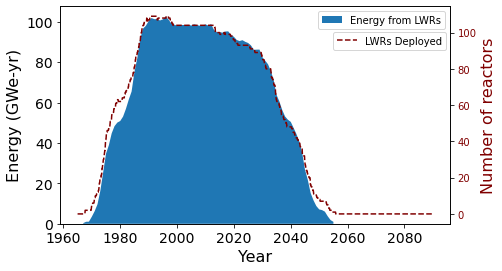

In [8]:
#combine energy and reactors for scenario 1 into a single plot
fig = plt.figure(figsize=(7,4))
ax1 = fig.add_subplot(111)
ax1.stackplot(s1_energy['Year'], s1_energy['Energy'], labels=['Energy from LWRs'])
ax1.legend()
ax1.set_ylabel('Energy (GWe-yr)', fontsize=16)

ax2 = ax1.twinx()
ax2.plot(s1_reactors['Year'], s1_reactors['lwr_total'], 'maroon', 
         linestyle='--', label='LWRs Deployed')
ax2.legend(loc=(0.7, 0.8))
ax2.set_ylabel('Number of reactors', color='maroon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='maroon')

ax1.set_xlabel('Year', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax2.tick_params(axis='both', which='minor', labelsize=14)
plt.savefig('figures/s1_energy_reactors.pdf', bbox_inches='tight')

In [9]:
s1_transactions = tm.add_receiver_prototype(s1_outfile)

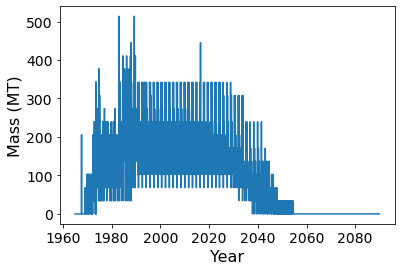

In [10]:
#Uranium resources sent to reactors
s1_uox = tm.commodity_mass_traded(s1_transactions, 'fresh_uox')
plt.plot(s1_uox['Year'], s1_uox['Quantity']/1000)
plt.ylabel('Mass (MT)', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/s1_uox.pdf', bbox_inches='tight')

In [11]:
print('Max uranium:',s1_uox['Quantity'].max()/1000)
print('Average across entire time:',s1_uox['Quantity'][32:1089].mean()/1000)
print('Average after 2025:',s1_uox['Quantity'][721:1089].mean()/1000)
print('Average before 2025:',s1_uox['Quantity'][32:721].mean()/1000)
print('Total after 2025:', s1_uox['Quantity'][721:].cumsum()[1499]/1000)
print('Total:', s1_uox['Quantity'].cumsum()[1499]/1000)

Max uranium: 513.7178423236442
Average across entire time: 135.74253053148882
Average after 2025: 81.11040952552757
Average before 2025: 164.92195074947685
Total after 2025: 29848.63070539421
Total: 143479.85477178285


1151208.2281102058


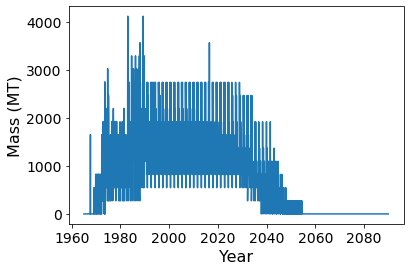

In [12]:
#Natural uranium needed
s1_tails = tm.calculate_tails(s1_uox['Quantity'], assays['LWR'], assays['tails'], assays['feed'])
s1_feed = tm.calculate_feed(s1_uox['Quantity'], s1_tails)
print(s1_feed.cumsum()[1499]/1000)

plt.plot(s1_uox['Year'], s1_feed/1000)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Mass (MT)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figures/s1_feed.pdf', bbox_inches='tight')

In [13]:
print('Maximum needed:',s1_feed.max()/1000)
print('Average feed:',s1_feed[32:1089].mean()/1000)
print('Average feed after 2025:', s1_feed[721:1089].mean()/1000)
print('Average feed before 2025:', s1_feed[32:721].mean()/1000)
print('Total after 2025:', s1_feed[721:].cumsum()[1499]/1000)
print('Total:', s1_feed.cumsum()[1499]/1000)

Maximum needed: 4121.806562675031
Average feed: 1089.1279357712408
Average feed after 2025: 650.7880216333915
Average feed before 2025: 1323.2485285183072
Total after 2025: 239489.9919610876
Total: 1151208.2281102058


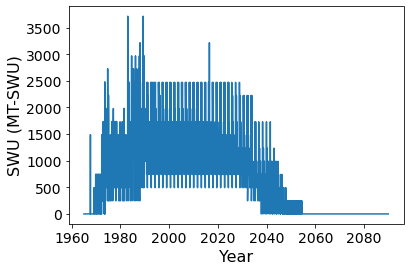

In [14]:
# SWU capacity 
s1_swu = tm.calculate_SWU(s1_uox['Quantity'], assays['LWR'], s1_tails, 
                          assays['tails'], s1_feed, assays['feed'])
plt.plot(s1_uox["Year"], s1_swu/1000)
plt.xlabel('Year', fontsize=16)
plt.ylabel('SWU (MT-SWU)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figures/s1_swu.pdf', bbox_inches='tight')

In [15]:
print('Maximum needed:',s1_swu.max()/1000)
print('Average SWU:',s1_swu[32:1089].mean()/1000)
print('Average SWU after 2025:', s1_swu[721:1089].mean()/1000)
print('Average SWU before 2025:', s1_swu[32:721].mean()/1000)

Maximum needed: 3714.1664210974054
Average SWU: 981.4149077135144
Average SWU after 2025: 586.4261169098742
Average SWU before 2025: 1192.3813446013803


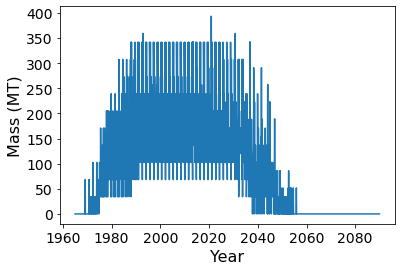

In [16]:
# waste discharged
s1_waste = tm.commodity_mass_traded(s1_transactions, 'spent_uox')

plt.plot(s1_waste['Year'], s1_waste['Quantity']/1000)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Mass (MT)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/s1_waste.pdf', bbox_inches='tight')

In [17]:
print('Maximum needed:',s1_waste['Quantity'].max())
print('Average waste:',s1_waste['Quantity'][32:1089].mean())
print('Average waste after 2025:', s1_waste['Quantity'][721:1089].mean())
print('Average waste before 2025:', s1_waste['Quantity'][32:721].mean())
print('Cumulative:', s1_waste['Quantity'].cumsum()[1499]/1000)

Maximum needed: 393622.40663899935
Average waste: 130113.73298735515
Average waste after 2025: 93898.30642251472
Average waste before 2025: 149456.66038338022
Cumulative: 137581.92946057965


## No growth scenarios

In [28]:
out_files_nogrowth = {'s2_outfile':"../outputs/mmr_nogrowth.sqlite",
            's3_outfile':"../outputs/xe100_nogrowth.sqlite",
            's4_outfile':"../outputs/xe100_mmr_nogrowth.sqlite",
            's5_outfile':"../outputs/mmr_voygr_nogrowth.sqlite",
            's6_outfile':"../outputs/xe100_voygr_nogrowth.sqlite",
            's7_outfile':"../outputs/xe100_mmr_voygr_nogrowth.sqlite"}

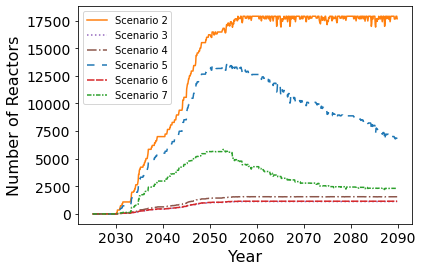

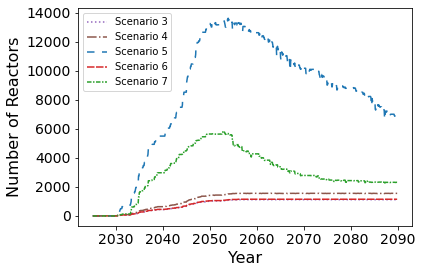

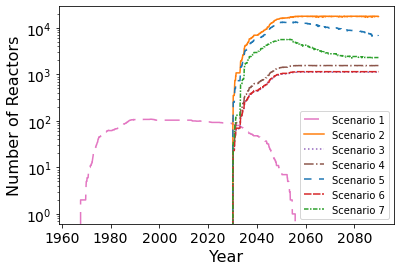

In [19]:
reactors_nogrowth = {'s2_reactors':'',
            's3_reactors':"",
            's4_reactors':"",
            's5_reactors':"",
            's6_reactors':"",
            's7_reactors':""}
plt.figure(0)
for key in reactors_nogrowth:
    scenario = key[:2]
    reactors_nogrowth[key] = tm.get_prototype_totals(out_files_nogrowth[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors_nogrowth[key]['Year'][721:], reactors_nogrowth[key]['advrx_total'][721:], 
             label=labels[scenario],
            color = colors[scenario], linestyle=lines[scenario])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('figures/nogrowth_reactors.pdf', bbox_inches='tight')

plt.figure(1)
for key in ['s3_reactors','s4_reactors','s5_reactors','s6_reactors','s7_reactors']:
    scenario = key[:2]
    reactors_nogrowth[key] = tm.get_prototype_totals(out_files_nogrowth[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors_nogrowth[key]['Year'][721:], reactors_nogrowth[key]['advrx_total'][721:], 
            label=labels[scenario],
            color=colors[scenario], linestyle=lines[scenario])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('figures/nogrowth_reactors_3-7.pdf', bbox_inches='tight')

plt.figure(2)
plt.plot(s1_reactors['Year'], s1_reactors['lwr_total'], label='Scenario 1', color='tab:pink', 
        linestyle=(0,(10,5)))
for key in reactors_nogrowth:
    scenario = key[:2]
    reactors_nogrowth[key] = tm.get_prototype_totals(out_files_nogrowth[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors_nogrowth[key]['Year'], reactors_nogrowth[key]['advrx_total'], 
             label=labels[scenario],
            color = colors[scenario], linestyle=lines[scenario])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.yscale('log')
plt.savefig('figures/reactors_1-7.pdf', bbox_inches='tight')

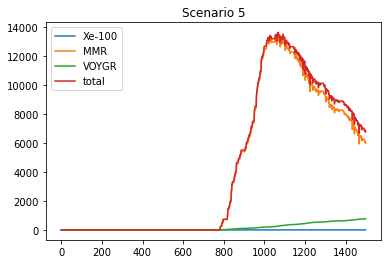

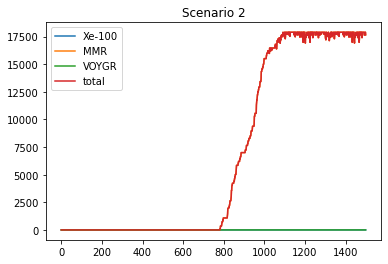

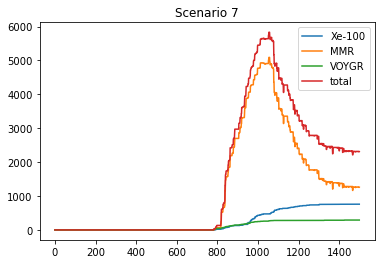

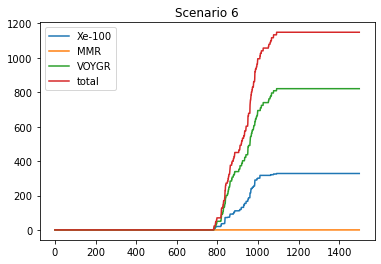

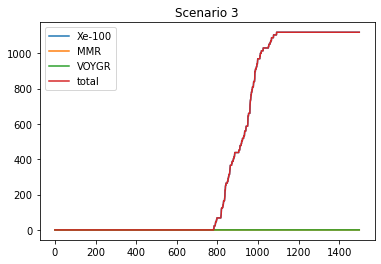

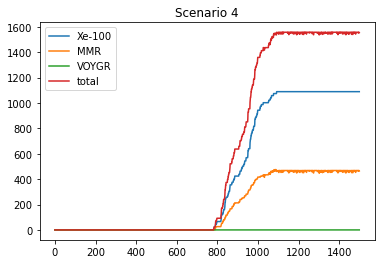

In [20]:
for scenario in plotting_order_nogrowth:
        plt.figure()
        for reactor in ['Xe-100', 'MMR', 'VOYGR']:
            num_rxs = reactors_nogrowth[scenario+'_reactors'][reactor+'_total']
            plt.plot(num_rxs, label = reactor)
        plt.plot(reactors_nogrowth[scenario+'_reactors']['advrx_total'], label='total')
        plt.legend()
        plt.title(labels[scenario])

In [21]:
for key in reactors_nogrowth:
    scenario = key[1]
    for adv_rx in adv_rxs:
        print(f'Max {adv_rx} in S{scenario}:', reactors_nogrowth[key][adv_rx +'_total'].max())
        print(f'Max {adv_rx} added in one step in S{scenario}:', reactors_nogrowth[key][adv_rx +'_enter'].max())
        prototype_sum = reactors_nogrowth[key][adv_rx +'_enter'].cumsum()
        print(f'Total number of {adv_rx} deployed in S{scenario}:', prototype_sum.iloc[-1])
    print(f'Max Adv Rx in S{scenario}:', reactors_nogrowth[key]['advrx_total'].max())
    print(f'Max Adv Rx added in one step in S{scenario}:', reactors_nogrowth[key]['advrx_enter'].max())
    advrx_sum = reactors_nogrowth[key]['advrx_enter'].cumsum()
    print(f'Total number of reactors deployed in S{scenario}:', advrx_sum.iloc[-1])  

Max MMR in S2: 17892.0
Max MMR added in one step in S2: 756.0
Total number of MMR deployed in S2: 51774.0
Max Xe-100 in S2: 0.0
Max Xe-100 added in one step in S2: 0.0
Total number of Xe-100 deployed in S2: 0.0
Max VOYGR in S2: 0.0
Max VOYGR added in one step in S2: 0.0
Total number of VOYGR deployed in S2: 0.0
Max Adv Rx in S2: 17892.0
Max Adv Rx added in one step in S2: 756.0
Total number of reactors deployed in S2: 51774.0
Max MMR in S3: 0.0
Max MMR added in one step in S3: 0.0
Total number of MMR deployed in S3: 0.0
Max Xe-100 in S3: 1119.0
Max Xe-100 added in one step in S3: 47.0
Total number of Xe-100 deployed in S3: 1119.0
Max VOYGR in S3: 0.0
Max VOYGR added in one step in S3: 0.0
Total number of VOYGR deployed in S3: 0.0
Max Adv Rx in S3: 1119.0
Max Adv Rx added in one step in S3: 47.0
Total number of reactors deployed in S3: 1119.0
Max MMR in S4: 475.0
Max MMR added in one step in S4: 15.0
Total number of MMR deployed in S4: 1358.0
Max Xe-100 in S4: 1089.0
Max Xe-100 added in

In [22]:
# Energy
energy_nogrowth = {'s2_energy':'', 's3_energy':'', 's4_energy':'',
          's5_energy':'', 's6_energy':'', 's7_energy':''}
for key in energy_nogrowth:
    scenario = key[:2]
    energy_nogrowth[key] = tm.get_annual_electricity(out_files_nogrowth[scenario + '_outfile'])

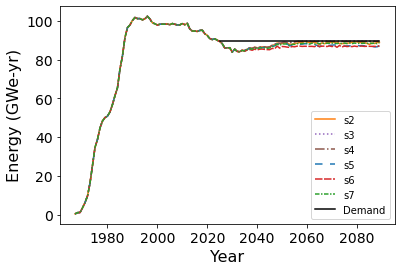

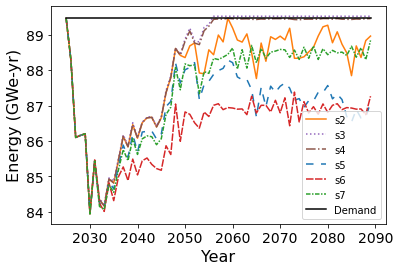

In [23]:
for key in energy_nogrowth:
    scenario = key[:2]
    
    plt.figure(0)
    plt.plot(energy_nogrowth[key]['Year'], energy_nogrowth[key]['Energy'], label=scenario,
            color=colors[scenario], linestyle=lines[scenario])
    
    plt.figure(1)
    plt.plot(energy_nogrowth[key]['Year'][58:], energy_nogrowth[key]['Energy'][58:], label=scenario,
            color=colors[scenario], linestyle=lines[scenario])
plt.figure(0)
plt.plot(np.linspace(2025,2089,65), np.repeat(89.45655, 65), 'k', label='Demand')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Energy (GWe-yr)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('figures/nogrowth_energy.pdf', bbox_inches='tight')

plt.figure(1)
plt.plot(np.linspace(2025,2089,65), np.repeat(89.45655, 65), 'k', label='Demand')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Energy (GWe-yr)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('figures/nogrowth_energy_after_2025.pdf', bbox_inches='tight')

s2_energy : -0.0034500000000008413 5.515800000000738
s3_energy : -0.06345000000000312 5.468300000000056
s4_energy : -0.0034500000000008413 5.515800000000013
s5_energy : 4.999999998744897e-05 5.516633333333928
s6_energy : 4.999999998744897e-05 5.502300000000048
s7_energy : 4.999999998744897e-05 5.51663333333336


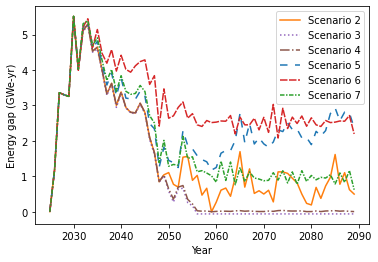

In [24]:
demand = np.repeat(89.45655,65)

for key in energy_nogrowth:
    scenario = key[:2]
    gap = demand-energy_nogrowth[key]['Energy'][58:]
    plt.plot(energy_nogrowth[key]['Year'][58:],gap, color = colors[scenario], linestyle = lines[scenario],
            label=labels[scenario])
    print(key, ':', gap.min(), gap.max())
plt.xlabel('Year')
plt.ylabel('Energy gap (GWe-yr)')
plt.legend()
plt.savefig('figures/nogrowth_energy_gap.pdf')

In [29]:
# Fuel mass
transactions_nogrowth = {'s2':'', 's3':'', 's4':'','s5':'', 's6':'','s7':''}
total_fuel_nogrowth = {'s2':'', 's3':'', 's4':'',
             's5':'', 's6':'', 's7':''}
for key in total_fuel_nogrowth:
    scenario = key[:2]
    transactions_nogrowth[scenario] = tm.add_receiver_prototype(out_files_nogrowth[scenario + '_outfile'])
    fuel = tm.commodity_mass_traded(transactions_nogrowth[scenario], 'fresh_uox')
    total_fuel_nogrowth[key] = tm.add_year(fuel)

In [33]:
#Dividing fuel mass by prototype
uranium_to_reactors_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'', 's2_total':'',
                       's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'', 's3_total':'',
                       's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'', 's4_total':'',
                       's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'', 's5_total':'',
                       's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'', 's6_total':'',
                       's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':'', 's7_total':'',}
for key in uranium_to_reactors_nogrowth:
    scenario = key[:2]
    reactor = key[3:]
    if reactor == 'LWR':
        uranium_to_reactors_nogrowth[key] = tm.commodity_to_LWR(transactions_nogrowth[scenario], 
                                                        'fresh_uox', adv_rxs)
    elif reactor != 'total': 
        uranium_to_reactors_nogrowth[key] = tm.commodity_to_prototype(transactions_nogrowth[scenario], 
                                                        'fresh_uox', reactor)
        uranium_to_reactors_nogrowth[key]['Quantity'] = uranium_to_reactors_nogrowth[key]['Quantity']*uranium_fractions[reactor]

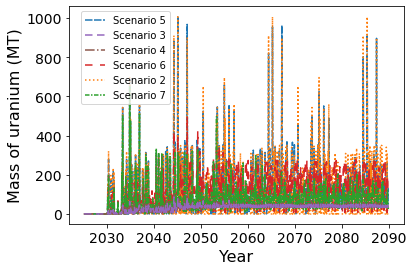

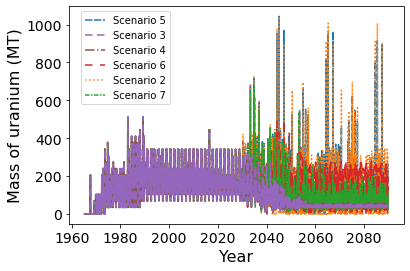

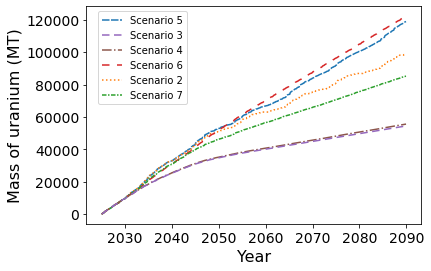

In [39]:
for key in ['s5','s2','s6','s7','s4','s3']:
      
    ax1 = plt.figure(1)
    AR_uranium = uranium_to_reactors_nogrowth[key + '_MMR'].copy()

    for reactor in ['Xe-100', 'VOYGR']:
        AR_uranium['Quantity'] += uranium_to_reactors_nogrowth[key+'_'+reactor]['Quantity']
    plt.plot(AR_uranium['Year'][721:], AR_uranium[721:]['Quantity']/1000, label=labels[key], 
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax2 = plt.figure(2)
    uranium_to_reactors_nogrowth[key + '_total'] = AR_uranium['Quantity'] 
    uranium_to_reactors_nogrowth[key + '_total'] += uranium_to_reactors_nogrowth[key+'_LWR']['Quantity']
    plt.plot(AR_uranium['Year'], uranium_to_reactors_nogrowth[key+'_total']/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax3 = plt.figure(3)
    plt.plot(uranium_to_reactors_nogrowth[key+'_MMR']['Year'][721:], 
            uranium_to_reactors_nogrowth[key+'_total'][721:].cumsum()/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
handles, legend_labels = ax1.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax1.savefig('figures/nogrowth_AR_uranium.pdf', bbox_inches='tight')
handles, legend_labels = ax2.gca().get_legend_handles_labels()
ax2.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax2.savefig('figures/nogrowth_uranium.pdf', bbox_inches='tight')
handles, legend_labels = ax3.gca().get_legend_handles_labels()
ax3.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax3.savefig('figures/nogrowth_uranium_cumulative.pdf', bbox_inches='tight')

In [28]:
#Reporting uranium masses
for scenario in plotting_order_nogrowth:
    HALEU_mass = uranium_to_reactors_nogrowth[scenario+'_MMR'] + uranium_to_reactors_nogrowth[scenario+'_Xe-100']
    print('Average HALEU mass in', scenario,'after 2025:', HALEU_mass[721:]['Quantity'].mean()/1000)
    AR_mass = HALEU_mass + uranium_to_reactors_nogrowth[scenario+'_VOYGR']
    print('Non-HALEU max:', uranium_to_reactors_nogrowth[scenario+'_VOYGR'][721:]['Quantity'].max()/1000)
    print('Average mass in', scenario, 'after 2025:', 
          AR_mass[721:]['Quantity'].mean()/1000)
    print('Maximum mass in', scenario, 'after 2025:', 
          AR_mass[721:]['Quantity'].max()/1000)

Average HALEU mass in s5 after 2025: 48.990195594440664
Non-HALEU max: 223.05493260764973
Average mass in s5 after 2025: 114.26415393344674
Maximum mass in s5 after 2025: 1009.688245570786
Average HALEU mass in s2 after 2025: 88.50955741028628
Non-HALEU max: 0.0
Average mass in s2 after 2025: 88.50955741028628
Maximum mass in s2 after 2025: 1006.7872404738916
Average HALEU mass in s7 after 2025: 31.887692250827456
Non-HALEU max: 267.6659191291798
Average mass in s7 after 2025: 70.94898666920061
Maximum mass in s7 after 2025: 648.64334288102
Average HALEU mass in s6 after 2025: 9.233023349594035
Non-HALEU max: 458.27649790299057
Average mass in s6 after 2025: 118.47761912130429
Maximum mass in s6 after 2025: 499.41949913499036
Average HALEU mass in s3 after 2025: 31.530644076385013
Non-HALEU max: 0.0
Average mass in s3 after 2025: 31.530644076385013
Maximum mass in s3 after 2025: 86.78601822375043
Average HALEU mass in s4 after 2025: 32.991198064259386
Non-HALEU max: 0.0
Average mass in

In [29]:
#SWU Calculations
tails_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'',
        's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'',
        's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'',
        's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'',
        's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'',
        's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':''}
feed_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'', 's2_total':'',
        's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'', 's3_total':'',
        's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'', 's4_total':'',
        's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'', 's5_total':'',
        's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'', 's6_total':'',
        's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':'', 's7_total':'',}
SWU_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'', 's2_total':'',
        's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'', 's3_total':'',
        's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'', 's4_total':'',
        's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'', 's5_total':'',
        's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'', 's6_total':'',
        's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':'', 's7_total':'',}
for key in feed_nogrowth:
    reactor = key[3:]
    if reactor != 'total':
        tails_nogrowth[key] = tm.calculate_tails(uranium_to_reactors_nogrowth[key]['Quantity'], 
                                    assays[reactor], assays['tails'], assays['feed'])
        feed_nogrowth[key] = tm.calculate_feed(uranium_to_reactors_nogrowth[key]['Quantity'], 
                                           tails_nogrowth[key])
        SWU_nogrowth[key] = tm.calculate_SWU(uranium_to_reactors_nogrowth[key]['Quantity'],
                                assays[reactor], tails_nogrowth[key], assays['tails'],
                                feed_nogrowth[key], assays['feed'])

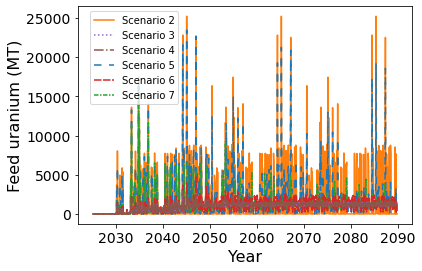

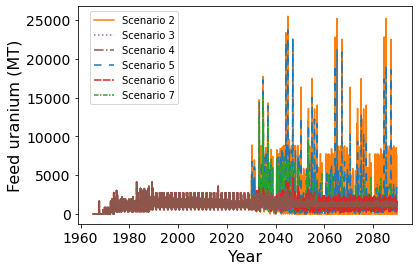

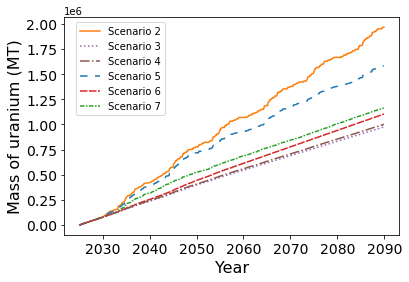

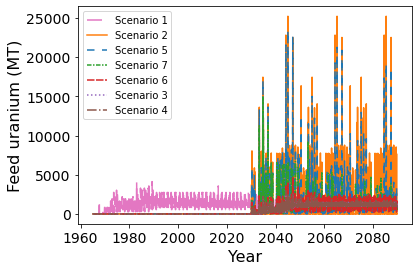

In [30]:
plt.figure(3)
plt.plot(s1_uox['Year'], s1_feed/1000, label='Scenario 1', color='tab:pink',
        linestyle=(0,(10,5)))
for key in ['s2','s5','s7','s6','s3','s4']:
    AR_feed = feed_nogrowth[key+'_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_feed += feed_nogrowth[key + '_' + reactor]
    ax0 = plt.figure(0)
    plt.plot(uranium_to_reactors_nogrowth[key + '_MMR']['Year'][721:], AR_feed[721:]/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax1 = plt.figure(1)
    feed_nogrowth[key+'_total'] = AR_feed + feed_nogrowth[key +'_LWR']
    plt.plot(uranium_to_reactors_nogrowth[key + '_MMR']['Year'], feed_nogrowth[key+'_total']/1000, 
             label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax2 = plt.figure(2)
    plt.plot(uranium_to_reactors_nogrowth[key+'_MMR']['Year'][721:], feed_nogrowth[key+'_total'][721:].cumsum()/1000, 
             label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.figure(3)
    plt.plot(uranium_to_reactors_nogrowth[key + '_MMR']['Year'], AR_feed/1000, 
             label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/feed_1-7.pdf', bbox_inches='tight')

order = [0, 4, 5, 1, 3, 2]
handles, legend_labels = ax0.gca().get_legend_handles_labels()
ax0.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax0.savefig('figures/nogrowth_AR_feed.pdf', bbox_inches='tight')
handles, legend_labels = ax2.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax1.savefig('figures/nogrowth_feed.pdf', bbox_inches='tight')
handles, legend_labels = ax2.gca().get_legend_handles_labels()
ax2.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax2.savefig('figures/nogrowth_feed_cumulative.pdf', bbox_inches='tight')

In [31]:
#Reporting feed masses
for scenario in plotting_order_nogrowth:
    HALEU_feed = feed_nogrowth[scenario+'_MMR'] + feed_nogrowth[scenario+'_Xe-100']
    print('Average feed for HALEU in',scenario, 'after 2025:', HALEU_feed[721:].mean()/1000)
    AR_feed = HALEU_feed + feed_nogrowth[scenario+'_VOYGR']
    print('AR Average mass in', scenario, 'after 2025:', AR_feed[721:].mean()/1000)
    print('AR Maximum mass in', scenario, 'after 2025:', AR_feed[721:].max()/1000)

Average feed for HALEU in s5 after 2025: 1227.1516704673984
AR Average mass in s5 after 2025: 1724.0512750441767
AR Maximum mass in s5 after 2025: 23453.037509124537
Average feed for HALEU in s2 after 2025: 2217.0691484377
AR Average mass in s2 after 2025: 2217.0691484377
AR Maximum mass in s2 after 2025: 25218.93674768261
Average feed for HALEU in s7 after 2025: 888.1503211063488
AR Average mass in s7 after 2025: 1185.5053803773303
AR Maximum mass in s7 after 2025: 14989.64115784618
Average feed for HALEU in s6 after 2025: 276.4486443224828
AR Average mass in s6 after 2025: 1108.0758019583984
AR Maximum mass in s6 after 2025: 4720.515647147223
Average feed for HALEU in s3 after 2025: 944.0682081579074
AR Average mass in s3 after 2025: 944.0682081579074
AR Maximum mass in s3 after 2025: 2598.4854771494747
Average feed for HALEU in s4 after 2025: 976.4411996172375
AR Average mass in s4 after 2025: 976.4411996172375
AR Maximum mass in s4 after 2025: 2973.1220063507217


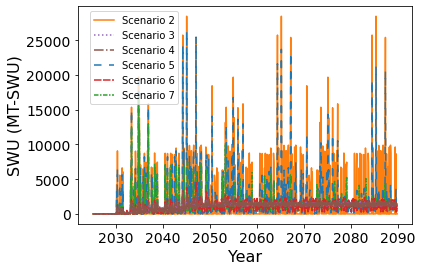

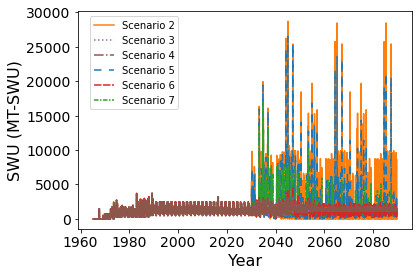

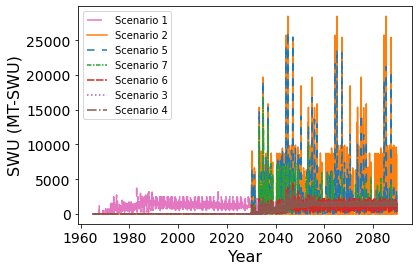

In [32]:
plt.figure(2)
plt.plot(s1_uox['Year'], s1_swu/1000, color='tab:pink', linestyle=(0,(10,5)),
        label='Scenario 1')
for key in ['s2', 's5', 's7', 's6','s3', 's4']:
    AR_SWU = SWU_nogrowth[key+'_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_SWU += SWU_nogrowth[key + '_' + reactor]
    ax0 = plt.figure(0)
    plt.plot(uranium_to_reactors_nogrowth[key + '_MMR']['Year'][721:], AR_SWU[721:]/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (MT-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax1 = plt.figure(1)
    SWU_nogrowth[key+'_total'] = AR_SWU + SWU_nogrowth[key +'_LWR']
    plt.plot(uranium_to_reactors_nogrowth[key + '_MMR']['Year'], SWU_nogrowth[key+'_total']/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (MT-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.figure(2)
    plt.plot(uranium_to_reactors_nogrowth[key + '_MMR']['Year'], AR_SWU/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (MT-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/swu_1-7.pdf', bbox_inches='tight')

handles, legend_labels = ax0.gca().get_legend_handles_labels()
ax0.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax0.savefig('figures/nogrowth_AR_SWU.pdf', bbox_inches='tight')
handles, legend_labels = ax1.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax1.savefig('figures/nogrowth_SWU.pdf', bbox_inches='tight')

In [34]:
#Reporting SWU Requirements
for scenario in plotting_order_nogrowth:
    HALEU_SWU = SWU_nogrowth[scenario+'_MMR'] + SWU_nogrowth[scenario+'_Xe-100']
    print('Average HALEU SWU in', scenario, 'after 2025:', HALEU_SWU[721:].mean()/1000)
    AR_SWU = HALEU_SWU + SWU_nogrowth[scenario+'_VOYGR']
    print('Average mass in ', scenario, ':', AR_SWU[721:].mean()/1000)
    print('Maximum mass in ', scenario, ':', AR_SWU[721:].max()/1000)

Average HALEU SWU in s5 after 2025: 1384.2319404140105
Average mass in  s5 : 1824.7651780574931
Maximum mass in  s5 : 26261.316087879404
Average HALEU SWU in s2 after 2025: 2500.862772899992
Average mass in  s2 : 2500.862772899992
Maximum mass in  s2 : 28447.060448629618
Average HALEU SWU in s7 after 2025: 1014.5782057088963
Average mass in  s7 : 1278.2024585434037
Maximum mass in  s7 : 16776.29502397226
Average HALEU SWU in s6 after 2025: 318.2730522689331
Average mass in  s6 : 1055.5636455621886
Maximum mass in  s6 : 4511.150218434648
Average HALEU SWU in s3 after 2025: 1086.8979694108166
Average mass in  s3 : 1086.8979694108166
Maximum mass in  s3 : 2991.6149746935052
Average HALEU SWU in s4 after 2025: 1122.8144866475
Average mass in  s4 : 1122.8144866475
Maximum mass in  s4 : 3413.6088021703727


In [35]:
# Waste discharged from reactors
waste_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'', 's2_total':'',
                    's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'', 's3_total':'',
                    's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'', 's4_total':'',
                    's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'', 's5_total':'',
                    's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'', 's6_total':'',
                    's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':'', 's7_total':''}
for key in waste_nogrowth:
    scenario = key[:2]
    reactor = key[3:]
    if reactor != 'total':
        waste_nogrowth[key] = tm.commodity_mass_traded(transactions_nogrowth[scenario], waste_commodity[reactor])

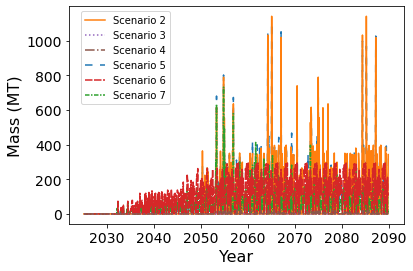

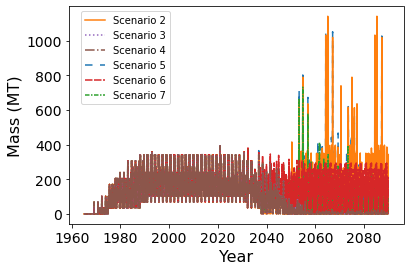

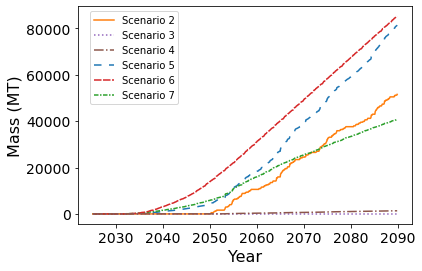

In [36]:
for key in plotting_order_nogrowth:
    AR_waste = waste_nogrowth[key + '_MMR'].copy()
    for reactor in ['Xe-100', 'VOYGR']:
        AR_waste['Quantity'] += waste_nogrowth[key + '_' + reactor]['Quantity']
    ax0 = plt.figure(0)
    plt.plot(AR_waste['Year'][721:], AR_waste['Quantity'][721:]/1000, label=labels[key], 
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax1 = plt.figure(1)
    waste_nogrowth[key+'_total'] = AR_waste['Quantity'] + waste_nogrowth[key + '_LWR']['Quantity']
    plt.plot(AR_waste['Year'], waste_nogrowth[key+'_total']/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax2 = plt.figure(2)
    plt.plot(AR_waste['Year'][721:], AR_waste['Quantity'][721:].cumsum()/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
handles, legend_labels = ax0.gca().get_legend_handles_labels()
ax0.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax0.savefig('figures/nogrowth_AR_waste.pdf', bbox_inches='tight')
handles, legend_labels = ax1.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax1.savefig('figures/nogrowth_waste.pdf', bbox_inches='tight')
handles, legend_labels = ax2.gca().get_legend_handles_labels()
ax2.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax2.savefig('figures/nogrowth_waste_cumulative.pdf', bbox_inches='tight')

In [37]:
#Reporting waste masses
for scenario in plotting_order_nogrowth:
    HALEU_waste = waste_nogrowth[scenario+'_MMR']['Quantity'] + waste_nogrowth[scenario+'_Xe-100']['Quantity']
    print('Average HALEU waste in', scenario, ': ', HALEU_waste[721:].mean()/1000)
    AR_waste = HALEU_waste + waste_nogrowth[scenario+'_VOYGR']['Quantity']
    print('Average AR waste in', scenario, 'after 2025:', AR_waste[721:].mean()/1000)
    print('Maximum  in', scenario, ':', AR_waste[721:].max()/1000)

Average HALEU waste in s5 :  43.987339237483845
Average AR waste in s5 after 2025: 104.46551536071877
Maximum  in s5 : 1104.037803999991
Average HALEU waste in s2 :  66.15070561489081
Average AR waste in s2 after 2025: 66.15070561489081
Maximum  in s2 : 1142.1542159999951
Average HALEU waste in s7 :  12.997802017971742
Average AR waste in s7 after 2025: 52.15505862901154
Maximum  in s7 : 732.45292
Average HALEU waste in s6 :  0.0
Average AR waste in s6 after 2025: 109.38635741976888
Maximum  in s6 : 294.45311999999984
Average HALEU waste in s3 :  0.0
Average AR waste in s3 after 2025: 0.0
Maximum  in s3 : 0.0
Average HALEU waste in s4 :  1.7318766341463419
Average AR waste in s4 after 2025: 1.7318766341463419
Maximum  in s4 : 22.66179


## 1% Growth Scenarios

In [3]:
out_files_1percent = {'s08_outfile':"../outputs/mmr_1percent.sqlite",
                    's09_outfile':"../outputs/xe100_1percent.sqlite",
            's10_outfile':"../outputs/xe100_mmr_1percent.sqlite",
            's11_outfile':"../outputs/mmr_voygr_1percent.sqlite",
            's12_outfile':"../outputs/xe100_voygr_1percent.sqlite",
            's13_outfile':"../outputs/xe100_mmr_voygr_1percent.sqlite"}

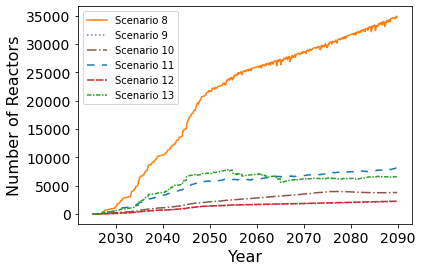

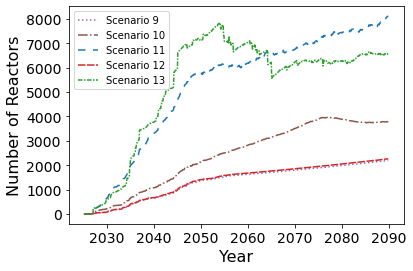

In [5]:
reactors_1percent = {'s08_reactors':"",'s09_reactors':"",
                    's10_reactors':"",'s11_reactors':"",
                    's12_reactors':"",'s13_reactors':""}
plt.figure(0)
for key in reactors_1percent:
    scenario = key[:3]
    reactors_1percent[key] = tm.get_prototype_totals(out_files_1percent[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors_1percent[key]['Year'][721:], reactors_1percent[key]['advrx_total'][721:], 
             label=labels[scenario], color=colors[scenario], linestyle=lines[scenario])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/1percent_reactors.pdf', bbox_inches='tight')

plt.figure(1)
for key in ['s09_reactors','s10_reactors','s11_reactors','s12_reactors','s13_reactors']:
    scenario = key[:3]
    reactors_1percent[key] = tm.get_prototype_totals(out_files_1percent[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors_1percent[key]['Year'][721:], reactors_1percent[key]['advrx_total'][721:], 
             label=labels[scenario], color=colors[scenario], linestyle=lines[scenario])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/1percent_reactors_9-13.pdf', bbox_inches='tight')

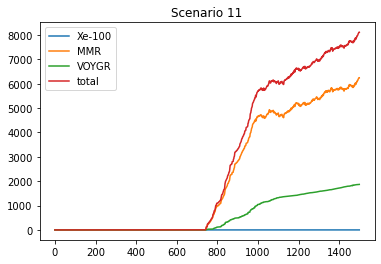

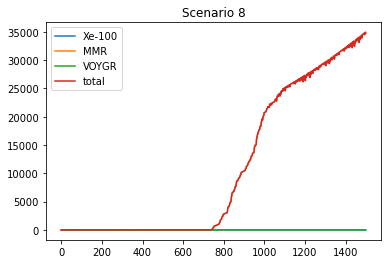

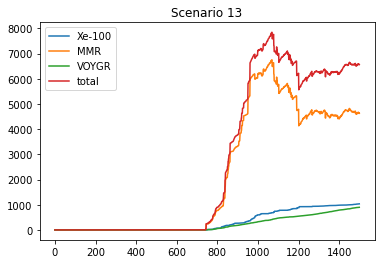

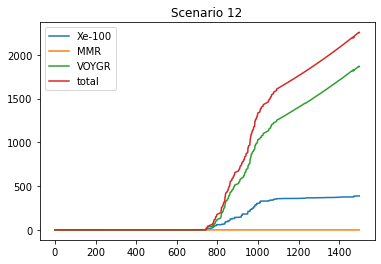

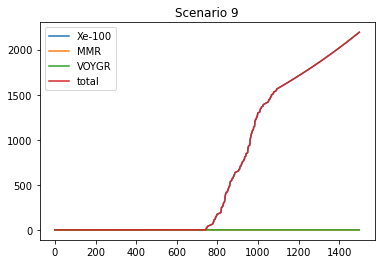

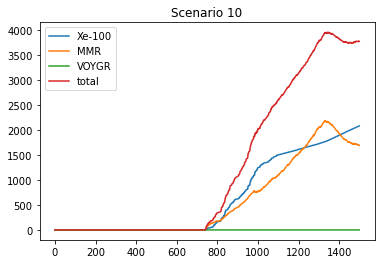

In [6]:
for scenario in plotting_order_1percent:
        plt.figure()
        for reactor in ['Xe-100', 'MMR', 'VOYGR']:
            num_rxs = reactors_1percent[scenario+'_reactors'][reactor+'_total']
            plt.plot(num_rxs, label = reactor)
        plt.plot(reactors_1percent[scenario+'_reactors']['advrx_total'], label='total')
        plt.legend()
        plt.title(labels[scenario])

In [7]:
for key in reactors_1percent:
    scenario = key[1:3]
    for adv_rx in adv_rxs:
        print(f'Max {adv_rx} in S{scenario}:', reactors_1percent[key][adv_rx +'_total'].max())
        print(f'Max {adv_rx} added in one step in S{scenario}:', reactors_1percent[key][adv_rx +'_enter'].max())
        prototype_sum = reactors_1percent[key][adv_rx +'_enter'].cumsum()
        print(f'Total number of {adv_rx} deployed in S{scenario}:', prototype_sum.iloc[-1])
    print(f'Max Adv Rx in S{scenario}:', reactors_1percent[key]['advrx_total'].max())
    print(f'Max Adv Rx added in one step in S{scenario}:', reactors_1percent[key]['advrx_enter'].max())
    advrx_sum = reactors_1percent[key]['advrx_enter'].cumsum()
    print(f'Total number of reactors deployed in S{scenario}:', advrx_sum.iloc[-1])  

Max MMR in S08: 34933.0
Max MMR added in one step in S08: 825.0
Total number of MMR deployed in S08: 86263.0
Max Xe-100 in S08: 0.0
Max Xe-100 added in one step in S08: 0.0
Total number of Xe-100 deployed in S08: 0.0
Max VOYGR in S08: 0.0
Max VOYGR added in one step in S08: 0.0
Total number of VOYGR deployed in S08: 0.0
Max Adv Rx in S08: 34933.0
Max Adv Rx added in one step in S08: 825.0
Total number of reactors deployed in S08: 86263.0
Max MMR in S09: 0.0
Max MMR added in one step in S09: 0.0
Total number of MMR deployed in S09: 0.0
Max Xe-100 in S09: 2193.0
Max Xe-100 added in one step in S09: 49.0
Total number of Xe-100 deployed in S09: 2193.0
Max VOYGR in S09: 0.0
Max VOYGR added in one step in S09: 0.0
Total number of VOYGR deployed in S09: 0.0
Max Adv Rx in S09: 2193.0
Max Adv Rx added in one step in S09: 49.0
Total number of reactors deployed in S09: 2193.0
Max MMR in S10: 2189.0
Max MMR added in one step in S10: 15.0
Total number of MMR deployed in S10: 4471.0
Max Xe-100 in S1

In [ ]:
# Energy
energy_1percent = {'s08_energy':'', 's09_energy':'', 's10_energy':'',
                  's11_energy':'', 's12_energy':'', 's13_energy':''}
for key in energy_1percent:
    scenario = key[:3]
    energy_1percent[key] = tm.get_annual_electricity(out_files_1percent[scenario + '_outfile'])

In [ ]:
demand = 89.45655* np.exp(0.01*(time-2025))

for key in energy_1percent:
    scenario = key[:3]
    gap = demand-energy_1percent[key]['Energy'][58:]
    plt.plot(energy_1percent[key]['Year'][58:],gap, color = colors[scenario], linestyle = lines[scenario], 
            label=labels[scenario])
    print(key, ':', gap.min(), gap.max())
plt.xlabel('Year')
plt.ylabel('Energy gap (GWe-yr)')
plt.legend()
plt.savefig('figures/1percent_energy_gap.pdf')

In [ ]:
for key in energy_1percent:
    scenario = key[:3]
    plt.figure(0)
    plt.plot(energy_1percent[key]['Year'], energy_1percent[key]['Energy'], label=labels[scenario],
            linestyle=lines[scenario], color=colors[scenario])
    
    plt.figure(1)
    plt.plot(energy_1percent[key]['Year'][58:], energy_1percent[key]['Energy'][58:], label=labels[scenario],
            linestyle=lines[scenario], color=colors[scenario])
plt.figure(0)
plt.plot(np.linspace(2025,2089,65), 89.45655* np.exp(0.01*(time-2025)), 'k', label='Demand')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Energy (GWe-yr)', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/1percent_energy.pdf', bbox_inches='tight')

plt.figure(1)
plt.plot(np.linspace(2025,2089,65), 89.45655* np.exp(0.01*(time-2025)), 'k', label='Demand')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Energy (GWe-yr)', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/1percent_energy_after_2025.pdf', bbox_inches='tight')

In [4]:
# Fuel mass
transactions_1percent = {'s08':'', 's09':'', 's10':'','s11':'', 's12':'','s13':''}
total_fuel_1percent = {'s08':'', 's09':'', 's10':'',
                       's11':'', 's12':'', 's13':''}

for key in total_fuel_1percent:
    scenario = key[:3]
    transactions_1percent[scenario] = tm.add_receiver_prototype(out_files_1percent[scenario + '_outfile'])
    fuel = tm.commodity_mass_traded(transactions_1percent[scenario], 'fresh_uox')
    total_fuel_1percent[key] = tm.add_year(fuel)

In [5]:
#Dividing fuel mass by prototype
uranium_to_reactors_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'', 's08_total':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'', 's09_total':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'', 's10_total':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'', 's11_total':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'', 's12_total':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':'', 's13_total':'',}

for key in uranium_to_reactors_1percent:
    scenario = key[:3]
    reactor = key[4:]
    if reactor == 'LWR':
        uranium_to_reactors_1percent[key] = tm.commodity_to_LWR(transactions_1percent[scenario], 
                                                        'fresh_uox', adv_rxs)
    elif reactor != 'total': 
        uranium_to_reactors_1percent[key] = tm.commodity_to_prototype(transactions_1percent[scenario], 
                                                        'fresh_uox', reactor)
        uranium_to_reactors_1percent[key]['Quantity'] = uranium_to_reactors_1percent[key]['Quantity']*uranium_fractions[reactor]

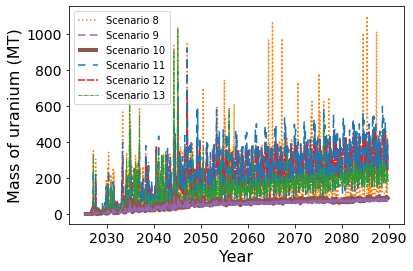

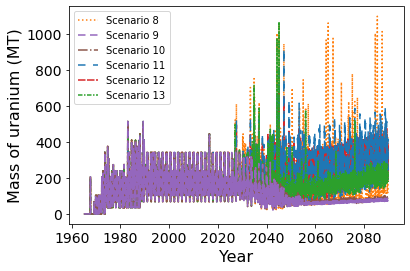

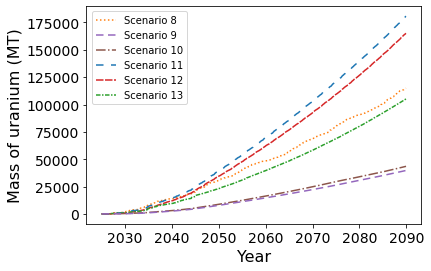

In [27]:
markers = {'s08':1.5,'s09':1.5,'s10':4,'s11':1.5,'s12':1.5,'s13':1}
for key in plotting_order_1percent:

    ax1 = plt.figure(1)
    AR_uranium = uranium_to_reactors_1percent[key + '_MMR'].copy()
    for reactor in ['Xe-100', 'VOYGR']:
        AR_uranium['Quantity'] += uranium_to_reactors_1percent[key+'_'+reactor]['Quantity']
    plt.plot(AR_uranium['Year'][721:], AR_uranium['Quantity'][721:]/1000, label=labels[key],
            linestyle=lines[key], color=colors[key], linewidth=markers[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('', bbox_inches='tight')

    ax2 = plt.figure(2)
    uranium_to_reactors_1percent[key+'_total'] = AR_uranium['Quantity'] + \
                                                uranium_to_reactors_1percent[key+'_LWR']['Quantity']
    plt.plot(AR_uranium['Year'], uranium_to_reactors_1percent[key+'_total']/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('', bbox_inches='tight')
    
    ax3 = plt.figure(3)
    plt.plot(AR_uranium['Year'][721:], AR_uranium['Quantity'][721:].cumsum()/1000, 
             label=labels[key], linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

handles, legend_labels = ax1.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax1.savefig('figures/1percent_AR_uranium.pdf', bbox_inches='tight')
handles, legend_labels = ax2.gca().get_legend_handles_labels()
ax2.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax2.savefig('figures/1percent_uranium.pdf', bbox_inches='tight')
handles, legend_labels = ax3.gca().get_legend_handles_labels()
ax3.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax3.savefig('figures/1percent_uranium_cumulative.pdf', bbox_inches='tight')

In [7]:
#Reporting uranium masses
for scenario in plotting_order_1percent:
    HALEU_mass = uranium_to_reactors_1percent[scenario+'_MMR']['Quantity'] + \
                uranium_to_reactors_1percent[scenario+'_Xe-100']['Quantity']
    print('Average HALEU mass in', scenario,'after 2025:', HALEU_mass[721:].mean()/1000)
    AR_mass = HALEU_mass + uranium_to_reactors_1percent[scenario+'_VOYGR']['Quantity']
    print('Average mass in ', scenario, ':', AR_mass[721:].mean()/1000)
    print('Maximum mass in ', scenario, ':', AR_mass[721:].max()/1000)    

Average HALEU mass in s11 after 2025: 28.547554741653567
Average mass in  s11 : 231.91826048060184
Maximum mass in  s11 : 918.9146702789485
Average HALEU mass in s08 after 2025: 147.4697715239992
Average mass in  s08 : 147.4697715239992
Maximum mass in  s08 : 1098.6765521044506
Average HALEU mass in s13 after 2025: 51.62352081011544
Average mass in  s13 : 134.87410844762115
Maximum mass in  s13 : 1033.5643784516737
Average HALEU mass in s12 after 2025: 10.422464522352701
Average mass in  s12 : 211.84088645390526
Maximum mass in  s12 : 650.9587422687289
Average HALEU mass in s09 after 2025: 50.95011425031447
Average mass in  s09 : 50.95011425031447
Maximum mass in  s09 : 103.50036247425084
Average HALEU mass in s10 after 2025: 55.83248626717366
Average mass in  s10 : 55.83248626717366
Maximum mass in  s10 : 114.69055473049062


In [8]:
#SWU Calculations
tails_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':''}

feed_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'', 's08_total':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'', 's09_total':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'', 's10_total':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'', 's11_total':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'', 's12_total':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':'', 's13_total':'',}

SWU_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'', 's08_total':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'', 's09_total':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'', 's10_total':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'', 's11_total':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'', 's12_total':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':'', 's13_total':'',}
for key in feed_1percent:
    scenario = key[:3]
    reactor = key[4:]
    if reactor != 'total':
        tails_1percent[key] = tm.calculate_tails(uranium_to_reactors_1percent[key]['Quantity'], 
                                    assays[reactor], assays['tails'], assays['feed'])
        feed_1percent[key] = tm.calculate_feed(uranium_to_reactors_1percent[key]['Quantity'], 
                                           tails_1percent[key])
        SWU_1percent[key] = tm.calculate_SWU(uranium_to_reactors_1percent[key]['Quantity'],
                                assays[reactor], tails_1percent[key], assays['tails'],
                                feed_1percent[key], assays['feed'])

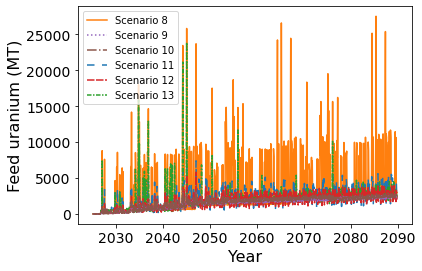

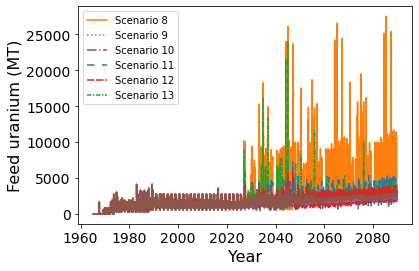

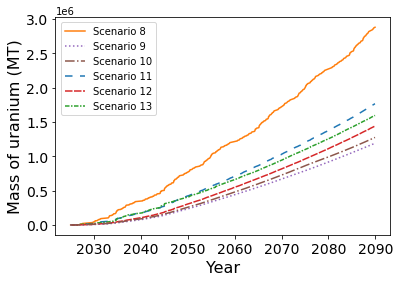

In [9]:
for key in ['s08','s11', 's13','s12','s09','s10']:
    AR_feed = feed_1percent[key+'_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_feed += feed_1percent[key + '_' + reactor]
    ax0 = plt.figure(0)
    plt.plot(uranium_to_reactors_1percent[key + '_MMR']['Year'][721:], AR_feed[721:]/1000, 
             label=labels[key], linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax1 = plt.figure(1)
    feed_1percent[key+'_total'] = AR_feed + feed_1percent[key +'_LWR']
    plt.plot(uranium_to_reactors_1percent[key + '_MMR']['Year'], feed_1percent[key+'_total']/1000, 
             label=labels[key], linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax2 = plt.figure(2)
    plt.plot(uranium_to_reactors_1percent[key+'_MMR']['Year'][721:], AR_feed[721:].cumsum()/1000, 
             label=labels[key], linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
order = [0, 4, 5, 1, 3, 2]
handles, legend_labels = ax0.gca().get_legend_handles_labels()
ax0.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax0.savefig('figures/1percent_AR_feed.pdf', bbox_inches='tight')
handles, legend_labels = ax1.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax1.savefig('figures/1percent_feed.pdf', bbox_inches='tight')
handles, legend_labels = ax2.gca().get_legend_handles_labels()
ax2.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax2.savefig('figures/1percent_feed_cumulative.pdf', bbox_inches='tight')

In [10]:
#Reporting feed masses
for scenario in plotting_order_1percent:
    HALEU_feed = feed_1percent[scenario+'_MMR']+feed_1percent[scenario+'_Xe-100']
    print('Average HALEU feed in',scenario,'after 2025:', HALEU_feed[721:].mean()/1000)
    AR_feed = HALEU_feed + feed_1percent[scenario+'_VOYGR']
    print('Average mass in ', scenario, ':', AR_feed[721:].mean()/1000)
    print('Maximum mass in ', scenario, ':', AR_feed[721:].max()/1000)

Average HALEU feed in s11 after 2025: 715.0855199474864
Average mass in  s11 : 2263.249992206799
Maximum mass in  s11 : 7573.542967419893
Average HALEU feed in s08 after 2025: 3693.95905187317
Average mass in  s08 : 3693.95905187317
Maximum mass in  s08 : 27520.6651016379
Average HALEU feed in s13 after 2025: 1412.299238146645
Average mass in  s13 : 2046.0463729996723
Maximum mass in  s13 : 23876.70793075966
Average HALEU feed in s12 after 2025: 312.0620492994057
Average mass in  s12 : 1845.364713318465
Maximum mass in  s12 : 5816.694811602552
Average HALEU feed in s09 after 2025: 1525.5122270642103
Average mass in  s09 : 1525.5122270642103
Maximum mass in  s09 : 3098.934532007902
Average HALEU feed in s10 after 2025: 1634.3027250375935
Average mass in  s10 : 1634.3027250375935
Maximum mass in  s10 : 3336.253706651725


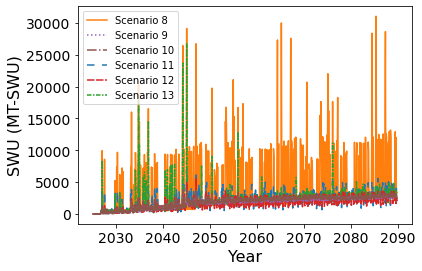

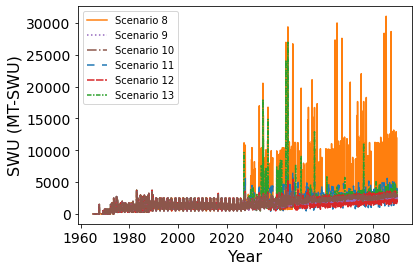

In [11]:
for key in ['s08','s11', 's13','s12','s09','s10']:
    AR_SWU = SWU_1percent[key+'_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_SWU += SWU_1percent[key + '_' + reactor]
    ax0 = plt.figure(0)
    plt.plot(uranium_to_reactors_1percent[key + '_MMR']['Year'][721:], AR_SWU[721:]/1000, 
             label=labels[key], linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (MT-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax1 = plt.figure(1)
    SWU_1percent[key+'_total'] = AR_SWU + SWU_1percent[key +'_LWR']
    plt.plot(uranium_to_reactors_1percent[key + '_MMR']['Year'], SWU_1percent[key+'_total']/1000, 
             label=labels[key], linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (MT-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
order = [0, 4, 5, 1, 3,2]
handles, legend_labels = ax0.gca().get_legend_handles_labels()
ax0.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax0.savefig('figures/1percent_AR_SWU.pdf', bbox_inches='tight')
handles, legend_labels = ax1.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax1.savefig('figures/1percent_SWU.pdf', bbox_inches='tight')

In [12]:
#Reporting SWU requirements
for scenario in plotting_order_1percent:
    HALEU_SWU = SWU_1percent[scenario+'_MMR'] + SWU_1percent[scenario+'_Xe-100']
    print('Average SWU for HALEU in', scenario, 'after 2025:', HALEU_SWU[721:].mean()/1000)
    AR_SWU = HALEU_SWU + SWU_1percent[scenario+'_VOYGR']
    print('Average capacity in ', scenario, ':', AR_SWU[721:].mean()/1000)
    print('Maximum capacity in ', scenario, ':', AR_SWU[721:].max()/1000)   

Average SWU for HALEU in s11 after 2025: 806.6192962617722
Average capacity in  s11 : 2179.1659859495226
Maximum capacity in  s11 : 7245.996918502139
Average SWU for HALEU in s08 after 2025: 4166.800428374711
Average capacity in  s08 : 4166.800428374711
Maximum capacity in  s08 : 31043.419140369773
Average SWU for HALEU in s13 after 2025: 1610.065638973336
Average capacity in  s13 : 2171.9229529912755
Maximum capacity in  s13 : 26722.235051668078
Average SWU for HALEU in s12 after 2025: 359.274472737006
Average capacity in  s12 : 1718.6452201599368
Maximum capacity in  s12 : 5462.6010892018385
Average SWU for HALEU in s09 after 2025: 1756.309689892797
Average capacity in  s09 : 1756.309689892797
Maximum capacity in  s09 : 3567.7778587085586
Average SWU for HALEU in s10 after 2025: 1877.1006694826235
Average capacity in  s10 : 1877.1006694826235
Maximum capacity in  s10 : 3829.348811970771


In [13]:
# Waste discharged from reactors

waste_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'', 's08_total':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'', 's09_total':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'', 's10_total':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'', 's11_total':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'', 's12_total':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':'', 's13_total':'',}

for key in waste_1percent:
    scenario = key[:3]
    reactor = key[4:]
    if reactor != 'total':
        waste_1percent[key] = tm.commodity_mass_traded(transactions_1percent[scenario], waste_commodity[reactor])

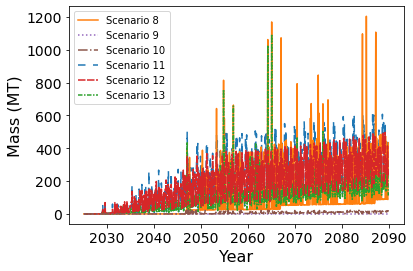

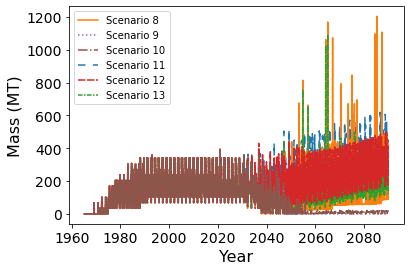

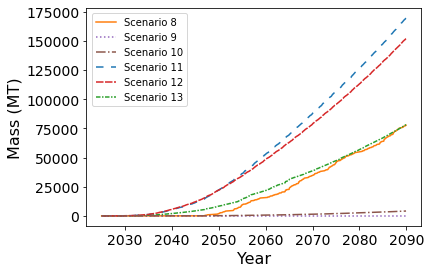

In [14]:
for key in plotting_order_1percent:
    AR_waste = waste_1percent[key + '_MMR'].copy()
    for reactor in ['Xe-100', 'VOYGR']:
        AR_waste['Quantity'] += waste_1percent[key + '_' + reactor]['Quantity']
    ax0 = plt.figure(0)
    plt.plot(AR_waste['Year'][721:], AR_waste['Quantity'][721:]/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
       
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax1 = plt.figure(1)
    waste_1percent[key+'_total'] = AR_waste['Quantity'] + waste_1percent[key + '_LWR']['Quantity']
    plt.plot(AR_waste['Year'], waste_1percent[key+'_total']/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax2 = plt.figure(2)
    plt.plot(AR_waste['Year'][721:], AR_waste['Quantity'][721:].cumsum()/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
handles, legend_labels = ax0.gca().get_legend_handles_labels()
ax0.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax0.savefig('figures/1percent_AR_waste.pdf', bbox_inches='tight')
handles, legend_labels = ax1.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax1.savefig('figures/1percent_waste.pdf', bbox_inches='tight')
handles, legend_labels = ax2.gca().get_legend_handles_labels()
ax2.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax2.savefig('figures/1percent_waste_cumulative.pdf', bbox_inches='tight')

In [15]:
#Reporting waste masses
for scenario in plotting_order_1percent:
    HALEU_waste = waste_1percent[scenario+'_MMR']['Quantity'] + waste_1percent[scenario+'_Xe-100']['Quantity']
    print('Average HALEU waste in',scenario,'after 2025:', HALEU_waste[721:].mean()/1000)
    AR_waste = HALEU_waste + waste_1percent[scenario+'_VOYGR']['Quantity']
    print('Average mass in ', scenario, ':', AR_waste[721:].mean()/1000)
    print('Maximum mass in ', scenario, ':', AR_waste[721:].max()/1000)

Average HALEU waste in s11 after 2025: 20.276338421052625
Average mass in  s11 : 217.68679124518613
Maximum mass in  s11 : 618.9850160000001
Average HALEU waste in s08 after 2025: 99.93296663414635
Average mass in  s08 : 99.93296663414635
Maximum mass in  s08 : 1204.0964419999984
Average HALEU waste in s13 after 2025: 21.948093917843362
Average mass in  s13 : 100.39254072143771
Maximum mass in  s13 : 1094.7676719999906
Average HALEU waste in s12 after 2025: 0.0
Average mass in  s12 : 195.14842729139923
Maximum mass in  s12 : 496.88964000000055
Average HALEU waste in s09 after 2025: 0.0
Average mass in  s09 : 0.0
Maximum mass in  s09 : 0.0
Average HALEU waste in s10 after 2025: 5.383750880616176
Average mass in  s10 : 5.383750880616176
Maximum mass in  s10 : 22.66179
